In [1]:
import cv2 as cv

# import cv2 as cv: This line imports the OpenCV library, which is a powerful computer vision library used for 
#various image and video processing tasks. It is imported with the name cv, which is a commonly used alias for OpenCV.

import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt: This line imports the pyplot module from the matplotlib library. It allows us to 
# display and plot images using the plt alias.

In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")# weights
# net = cv.dnn.readNetFromTensorflow("graph_opt.pb"): This line reads a pre-trained neural network from a TensorFlow model 
# file (graph_opt.pb) and creates a neural network object net. The neural network is trained for pose estimation.

In [3]:
inWidth = 368
# inWidth = 368: This line sets the input width of the image for the pose estimation model to 368 pixels.

inHeight = 368
# inHeight = 368: This line sets the input height of the image for the pose estimation model to 368 pixels.

thr = 0.2
# thr = 0.2: This line sets a threshold value of 0.2. During pose estimation, only body parts with confidence scores higher
# than this threshold will be considered.

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
# BODY_PARTS: This line defines a dictionary that maps human body part names (e.g., "Nose", "Neck") to their corresponding
# index in the neural network output.


POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

# POSE_PAIRS: This line defines a list of pairs of body parts that are used to draw lines between them when visualizing
# the estimated pose.

#### POSE ESTIMATION USING IMAGE

In [5]:
img = cv.imread("image.jpg") 
# img = cv.imread("image.jpg"): This line reads an image from the file named "image.jpg" using the OpenCV library's 
# imread() function. The image is loaded and stored in the variable img.

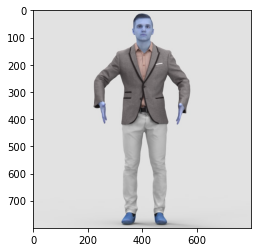

In [6]:
plt.imshow(img) #BGR
#plt.imshow(img) #BGR: This line uses the imshow() function from the matplotlib.pyplot library to display the image stored
# in the img variable. However, it shows the image in its original color format, which is BGR (Blue-Green-Red). In the BGR
# format, the color channels are arranged in the order of blue, green, and red.

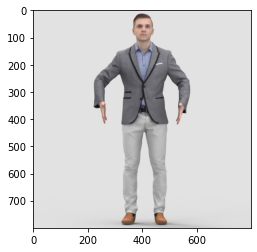

In [7]:
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
# plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)): This line converts the image from the BGR color format to the RGB color
# format using the cv.cvtColor() function from the OpenCV library. The cv.COLOR_BGR2RGB parameter tells OpenCV to perform 
# the conversion from BGR to RGB. RGB stands for Red-Green-Blue, which is the standard color format used for displaying 
# images on most screens.

In [8]:
# 255/2=127.5
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need 19 elements
    assert len(BODY_PARTS) == out.shape[1]
    points = []  # list
    for i in range(len(BODY_PARTS)):
        # SLICE HEATMAP OF CORRESPONDING BODY'S PART
        heatmap = out[0, i, :, :]
        # Originally, we try to find all the local maximums. To simplify a sample, we just find a global one.
        # However, only a single pose at the same time could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatmap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if its confidence is higher than the threshold
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert partFrom in BODY_PARTS
        assert partTo in BODY_PARTS

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    return frame


        
# frameWidth = frame.shape[1] and frameHeight = frame.shape[0]: These lines calculate the width and height of the input
# frame image. The frame.shape attribute returns a tuple with three elements: height, width, and channels. 
# We are extracting the width and height from this tuple.

# net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False)): 
# This line sets the input to the neural network model. The cv.dnn.blobFromImage() function prepares the image for 
# deep learning models. It resizes the frame to the specified inWidth and inHeight dimensions, scales the pixel values
# to a range of 0 to 1, and applies mean subtraction (127.5, 127.5, 127.5) for normalization.

# out = net.forward(): This line performs forward pass inference using the neural network model net with the preprocessed 
# input frame. The net.forward() method computes the output of the model, which is used for pose estimation.

# out = out[:, :19, :, :]: Here, we are selecting only the first 19 elements from the output out. The model output contains
# 57 elements, but we are interested in the first 19 elements, which represent the body parts' heatmaps.

# assert(len(BODY_PARTS) == out.shape[1]): This line checks whether the number of BODY_PARTS (body part types to detect)
# matches the number of channels in the out array. If they don't match, the code will raise an exception.

# points = []: This creates an empty list named points where we will store the detected body parts' coordinates.

# The for loop runs for each body part:

# a. heatmap = out[0, i, :, :]: This line extracts the heatmap corresponding to the current body part i.

# b. _, conf, _, point = cv.minMaxLoc(heatmap): The cv.minMaxLoc() function finds the highest value (confidence) and
# its location (point) in the heatmap.

# c. x = (frameWidth * point[0]) / out.shape[3] and y = (frameHeight * point[1]) / out.shape[2]: These lines convert 
# the point's location from heatmap space to the original image space.

# d. points.append((int(x), int(y)) if conf > thr else None): If the confidence (conf) of the detected body part is higher 
# than a threshold (thr), we add the (x, y) coordinate to the points list. Otherwise, we add None to indicate that the body part was not confidently detected.

# The for loop then iterates through pairs of body parts:

# a. partFrom and partTo are the names of the body parts in the current pair.

# b. idFrom = BODY_PARTS[partFrom] and idTo = BODY_PARTS[partTo]: These lines get the corresponding IDs (indices) of 
# the body parts in the points list.

# c. The if points[idFrom] and points[idTo]: condition checks if both the idFrom and idTo body parts were confidently 
# detected (not None).

# d. If both body parts are detected, lines and points are drawn on the frame image to visualize the pose estimation.

# return frame: Finally, this line returns the processed frame image, where lines and points have been drawn to visualize 
# the estimated pose.

# The pose_estimation() function takes an input frame (image) and performs pose estimation using a pre-trained neural
# network. It detects specific body parts' locations in the image and draws lines and points on the image to visualize 
# the estimated pose. The processed frame is then returned for display or further analysis.

In [9]:
estimated_image = pose_estimation(img)
estimated_image
 # STORING THE FUNCTION IN TO VARIABLE 

array([[[226, 226, 226],
        [226, 226, 226],
        [226, 226, 226],
        ...,
        [226, 226, 226],
        [226, 226, 226],
        [226, 226, 226]],

       [[226, 226, 226],
        [226, 226, 226],
        [226, 226, 226],
        ...,
        [226, 226, 226],
        [226, 226, 226],
        [226, 226, 226]],

       [[226, 226, 226],
        [226, 226, 226],
        [226, 226, 226],
        ...,
        [226, 226, 226],
        [226, 226, 226],
        [226, 226, 226]],

       ...,

       [[225, 225, 225],
        [225, 225, 225],
        [225, 225, 225],
        ...,
        [222, 222, 222],
        [222, 222, 222],
        [222, 222, 222]],

       [[225, 225, 225],
        [225, 225, 225],
        [225, 225, 225],
        ...,
        [221, 221, 221],
        [221, 221, 221],
        [221, 221, 221]],

       [[225, 225, 225],
        [225, 225, 225],
        [225, 225, 225],
        ...,
        [221, 221, 221],
        [221, 221, 221],
        [221, 221, 221]]

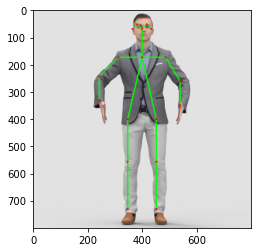

In [10]:
plt.imshow(cv.cvtColor(estimated_image,cv.COLOR_BGR2RGB))
# PRINTING THE VARIABLE WHICH STORES POSE ESTIMATION FUNCTION AND CONVERTING THE IMAGEINTO RGB

#### POSE ESTIMATION USING VIDEO

In [11]:

cap = cv.VideoCapture("boy_-_21827 (540p).mp4")
cap.set(3, 800) #height
cap.set(4, 800) #width
if not cap.isOpened():
    cap=cv.VideoCapture(0)
if not cap.isOpened():
    cap=cv.VideoCapture(0)
    raise IOError("CANNOT OPEN VIDEO")
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth =frame.shape[1]
    frameHeight=frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight),(127.5,127.5,127.5),swapRB=True,crop=False))
    out =net.forward()
    out = out[:, :19, :, :] # MobileNet output [1,57,-1,-1],we only need 19 elements
    assert(len(BODY_PARTS)==out.shape[1])
    points = []# list
    for i in range(len(BODY_PARTS)):
        #SLICE HEATMAP OF CORRESPONDING BODY'S PART
        heatmap = out[0, i, :, :]
        #originally,we try to find all the local maximums.To simplify a sample we just find a global one.However only a
        # single pose at the sametime could be detected this way
        _, conf, _, point=cv.minMaxLoc(heatmap)
        x = (frameWidth  * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) /out.shape[2]
        #ass a point if it's confidence is higher than threshold 
        points.append((int(x), int(y)) if conf > thr else None)
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
        
        idFrom =BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if points[idFrom] and points[idTo]:
            cv.line(frame,points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame,points[idFrom],  (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame,points[idTo],  (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' %(t/ freq), (10,20), cv.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0))

    cv.imshow("POSE ESTIMATION TUTORIAL", frame)
        # Exit the loop when the 'q' key is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the display window
cap.release()
cv.destroyAllWindows()
    
# cap = cv.VideoCapture("boy_-_21827 (540p).mp4"): This line creates a VideoCapture object named cap, which is used to
# read frames from the video file "boy_-_21827 (540p).mp4".

# cap.set(3, 800): This line sets the width of the captured frame to 800 pixels.

# cap.set(3, 800): This line sets the height of the captured frame to 800 pixels. 

# if not cap.isOpened():: This line checks if the video capture object cap is not opened (failed to open the video file).

# cap=cv.VideoCapture(0): If the video file couldn't be opened, this line tries to open the default camera (webcam)
# by creating a new VideoCapture object.

# if not cap.isOpened():: This line checks again if the camera couldn't be opened.

# cap=cv.VideoCapture(0): If the camera couldn't be opened, this line raises an IOError with the message 
# "CANNOT OPEN VIDEO" to indicate that no video source could be accessed.

# while cv.waitKey(1) < 0:: This starts a loop that continuously captures frames from the video or camera until
# a key is pressed (keyboard event) with a delay of 1 millisecond between each frame.

# hasFrame, frame = cap.read(): This line reads the next frame from the video or camera and stores it in the frame variable. The hasFrame variable will be True if a frame is successfully read, or False if there are no more frames (end of video or camera stream).

# if not hasFrame:: This line checks if the frame reading was unsuccessful, which indicates that there are no more frames
# to read from the video or camera.

# cv.waitKey(): If there are no more frames to read, this line waits for a keyboard event (key press) indefinitely.

# break: This line breaks out of the while loop when there are no more frames to read.

# The remaining lines are the actual pose estimation code. It uses the OpenCV DNN module to process the captured frame 
# and estimate the poses. The net object is a pre-trained neural network used for pose estimation.

# The for loop iterates over each body part and detects the corresponding body points using the neural network's output.

# It then draws lines and points on the frame based on the detected body points to visualize the poses.

# t, _ = net.getPerfProfile(): This line calculates the inference time taken by the neural network to estimate the poses.

# freq = cv.getTickFrequency() / 1000: This line calculates the frequency of the CPU clock, which is used to convert
# the inference time into milliseconds.

# cv.putText(...): This line adds a text label to the frame, showing the time taken for pose estimation.

# cv.imshow("POSE ESTIMATION TUTORIAL", frame): This line displays the frame with the estimated poses and the 
# inference time in a window named "POSE ESTIMATION TUTORIAL".

# The code continues to loop, capturing frames, performing pose estimation, and displaying the results until the user
 # presses a key, at which point the program will exit the loop and terminate.

#### POSE ESTIMATION USING REAL TIME WEBCAM


In [12]:
cap = cv.VideoCapture(1)
cap.set(cv.CAP_PROP_FPS, 10)
cap.set(3, 800) #height
cap.set(3, 800) #width
if not cap.isOpened():
    cap=cv.VideoCapture(0)
if not cap.isOpened():
    cap=cv.VideoCapture(0)
    raise IOError("CANNOT OPEN WEBCAM")
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth =frame.shape[1]
    frameHeight=frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight),(127.5,127.5,127.5),swapRB=True,crop=False))
    out =net.forward()
    out = out[:, :19, :, :] # MobileNet output [1,57,-1,-1],we only need 19 elements
    assert(len(BODY_PARTS)==out.shape[1])
    points = []# list
    for i in range(len(BODY_PARTS)):
        #SLICE HEATMAP OF CORRESPONDING BODY'S PART
        heatmap = out[0, i, :, :]
        #originally,we try to find all the local maximums.To simplify a sample we just find a global one.However only a
        # single pose at the sametime could be detected this way
        _, conf, _, point=cv.minMaxLoc(heatmap)
        x = (frameWidth  * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) /out.shape[2]
        #ass a point if it's confidence is higher than threshold 
        points.append((int(x), int(y)) if conf > thr else None)
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
        
        idFrom =BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if points[idFrom] and points[idTo]:
            cv.line(frame,points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame,points[idFrom],  (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame,points[idTo],  (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' %(t/ freq), (10,20), cv.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0))

    cv.imshow("POSE ESTIMATION TUTORIAL", frame)
        # Exit the loop when the 'q' key is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the display window
cap.release()
cv.destroyAllWindows()
    
# cap = cv.VideoCapture(1): This line creates a VideoCapture object cap to access a video stream from a webcam. 
# The argument 1 indicates that it's trying to access the second webcam (camera with ID 1). It's capturing frames
# from the webcam to process them further.

# cap.set(cv.CAP_PROP_FPS, 10): This line sets the frame rate of the webcam to 10 frames per second. It limits the 
# number of frames captured per second.

# cap.set(3, 800): This line sets the height of the captured frame to 800 pixels. It configures the camera to capture 
# frames with a specific height.

# cap.set(3, 800): This line sets the width of the captured frame to 800 pixels. It configures the camera to capture
# frames with a specific width.

# if not cap.isOpened():: This line checks if the webcam has been opened successfully. If not, it attempts to open it
# again by creating a new VideoCapture object for camera ID 0 (which is typically the default camera).

# if not cap.isOpened():: This line checks if the webcam has been opened successfully again. If it fails to open the 
# camera even with ID 0, it raises an IOError and displays "CANNOT OPEN WEBCAM".

# The following lines are inside a while loop, which means they will be executed repeatedly until a key is pressed:

# hasFrame, frame = cap.read(): This line reads a frame from the webcam and stores it in the variable frame. hasFrame
# is a boolean variable that indicates whether the frame was successfully read or not.

# if not hasFrame:: This line checks if the frame reading was unsuccessful (for example, when the camera is disconnected).
# If so, the program waits for a key press and then breaks out of the loop, terminating the program.

# frameWidth = frame.shape[1] and frameHeight = frame.shape[0]: These lines retrieve the width and height of the captured 
# frame, respectively, using the shape attribute of the frame variable.

# net.setInput(...): This line prepares the frame for input to a pre-trained neural network by performing certain
# preprocessing steps like resizing and normalization.

# out = net.forward(): This line passes the preprocessed frame through a neural network called net, and out contains 
# the network's output.

# out = out[:, :19, :, :]: This line extracts only the relevant output from the network. The network's output is in a
# specific format, and we are selecting the first 19 elements for further processing.

# The next few lines perform the pose estimation process:

# The out tensor contains heatmaps for each body part.
# It iterates over each body part, finds the most confident point (local maximum) in the heatmap, and adds the 
# corresponding point to the points list.
# The points list will hold the detected body keypoints (like nose, eyes, etc.) with their (x, y) coordinates.
# The following lines draw lines and points on the original frame to represent the detected pose using the points list.

# t, _ = net.getPerfProfile() and freq = cv.getTickFrequency() / 1000: These lines measure the time taken for the neural 
# network to process the frame and convert the frequency to milliseconds.

# cv.putText(...): This line adds the processing time to the frame as a text overlay.

# cv.imshow("POSE ESTIMATION TUTORIAL", frame): This line displays the processed frame with the detected pose using 
# OpenCV's imshow function.

# Overall, this code captures video from the webcam, processes each frame to estimate human pose, and then displays 
# the frames with the estimated pose overlaid on them. The loop continues until a key is pressed, and the program exits
# gracefully when the webcam is disconnected or when the user presses a key.

#### Fitness Tracking (Example: Counting Arm Raises):

In [13]:
import math
def pose_estimation1(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1,57,-1,-1], we only need 19 elements
    assert (len(BODY_PARTS) == out.shape[1])
    points = []  # list
    for i in range(len(BODY_PARTS)):
        # SLICE HEATMAP OF CORRESPONDING BODY'S PART
        heatmap = out[0, i, :, :]
        # Originally, we try to find all the local maximums. To simplify a sample we just find a global one.
        # However, only a single pose at the same time could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatmap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if its confidence is higher than the threshold
        points.append((int(x), int(y)) if conf > thr else None)
    return points
def count_arm_raises(points):
    if points is None:
        return False

    left_shoulder = points[BODY_PARTS["LShoulder"]]
    left_elbow = points[BODY_PARTS["LElbow"]]
    right_shoulder = points[BODY_PARTS["RShoulder"]]
    right_elbow = points[BODY_PARTS["RElbow"]]

    if all(keypoint is not None for keypoint in [left_shoulder, left_elbow, right_shoulder, right_elbow]):
        # Assume an arm raise when the angle between shoulders and elbows is small
        left_angle = abs(math.atan2(left_elbow[1] - left_shoulder[1], left_elbow[0] - left_shoulder[0]))
        right_angle = abs(math.atan2(right_elbow[1] - right_shoulder[1], right_elbow[0] - right_shoulder[0]))
        angle_threshold = math.radians(90)  # Adjust the threshold as needed

        if left_angle < angle_threshold and right_angle < angle_threshold:
            return True

    return False


cap = cv.VideoCapture("boy_-_21827 (540p).mp4")
cap.set(3, 800) #height
cap.set(4, 800) #width
if not cap.isOpened():
    cap=cv.VideoCapture(0)
if not cap.isOpened():
    cap=cv.VideoCapture(0)
    raise IOError("CANNOT OPEN VIDEO")
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break


    # Perform pose estimation and store the keypoints
    points = pose_estimation1(frame)

    # After pose estimation, analyze the pose for fitness tracking
    if count_arm_raises(points):
        print("Arm Raise Detected!")

    # Display the frame with keypoints and pose analysis
    cv.imshow("POSE ESTIMATION TUTORIAL", frame)

    # Exit the loop when the 'q' key is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the display window
cap.release()
cv.destroyAllWindows()


# import math: Import the math module, which provides mathematical functions like atan2 used for angle calculations.

# def pose_estimation1(frame): Define a function pose_estimation1 that takes a frame (an image or a video frame) as input
# and performs pose estimation using a pre-trained deep learning model.

# frameWidth = frame.shape[1]: Get the width of the input frame.

# frameHeight = frame.shape[0]: Get the height of the input frame.

# net.setInput(...): Set the input blob for the deep learning network using cv.dnn.blobFromImage(). This function
# preprocesses the frame and prepares it for inference.

# out = net.forward(): Forward pass the preprocessed frame through the deep learning network and get the output.

# out = out[:, :19, :, :]: The network outputs a 4-dimensional array, but we only need the first 19 elements 
# (corresponding to body parts), so this line truncates the output.

# assert (len(BODY_PARTS) == out.shape[1]): Ensure that the number of body parts detected by the network matches 
# the expected number.

# points = []: Initialize an empty list points to store the detected keypoints (body part positions).

# for i in range(len(BODY_PARTS)): ...: Iterate through the body parts.

# heatmap = out[0, i, :, :]: Get the heatmap for the corresponding body part.

# _, conf, _, point = cv.minMaxLoc(heatmap): Find the location (point) with the maximum confidence in the heatmap.

# x = (frameWidth * point[0]) / out.shape[3]: Calculate the x-coordinate of the detected keypoint in the original frame.

# y = (frameHeight * point[1]) / out.shape[2]: Calculate the y-coordinate of the detected keypoint in the original frame.

# points.append(... if conf > thr else None): Add the detected keypoint (as a tuple of x, y coordinates) to the points
# list if its confidence is higher than a specified threshold thr, otherwise add None.

# return points: Return the list of detected keypoints (points).

# def count_arm_raises(points): Define a function count_arm_raises that takes the detected points as input and checks
# if an arm raise gesture is detected.

# if points is None:: Check if points is None (i.e., if no keypoints are detected), and return False in that case.

# Extract the left and right shoulder, elbow keypoints from points.

# if all(keypoint is not None for keypoint in ...):: Check if all the required keypoints for the arms 
# (left shoulder, left elbow, right shoulder, right elbow) are detected.

# Calculate the angles between the shoulders and elbows on both sides using math.atan2.

# angle_threshold = math.radians(90): Set the threshold angle for detecting an arm raise (in radians).

# Check if both left and right arm angles are less than the angle_threshold, and if so, return True to indicate that an
# arm raise is detected.

# return False: If the conditions for arm raise are not met, return False.

# The remaining code sets up video capture using the specified video file or webcam and enters a loop to process frames.

# points = pose_estimation1(frame): Perform pose estimation on the current frame and get the detected keypoints.

# if count_arm_raises(points):: Check if an arm raise gesture is detected in the current frame using the count_arm_raises
# function.

# If an arm raise is detected, print the message "Arm Raise Detected!"

# cv.imshow("POSE ESTIMATION TUTORIAL", frame): Display the frame with keypoints and pose analysis.

# if cv.waitKey(1) & 0xFF == ord('q'):: Check if the 'q' key is pressed. If so, break out of the loop and stop the program.

# Finally, release the video capture and close the display window.

# The code performs pose estimation using a deep learning model, extracts key body part positions, and then checks 
# for the "Arm Raise" gesture based on the angles between the shoulders and elbows. If detected, it displays the message 
# "Arm Raise Detected!" on the frame.

Arm Raise Detected!
Arm Raise Detected!
Arm Raise Detected!


##### Gesture Recognition (Example: Detecting "Thumbs Up"): 

In [14]:
import math
def pose_estimation1(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1,57,-1,-1], we only need 19 elements
    assert (len(BODY_PARTS) == out.shape[1])
    points = []  # list
    for i in range(len(BODY_PARTS)):
        # SLICE HEATMAP OF CORRESPONDING BODY'S PART
        heatmap = out[0, i, :, :]
        # Originally, we try to find all the local maximums. To simplify a sample we just find a global one.
        # However, only a single pose at the same time could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatmap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if its confidence is higher than the threshold
        points.append((int(x), int(y)) if conf > thr else None)
    return points
def is_thumbs_up(points):
    left_wrist = points[BODY_PARTS["LWrist"]]
    right_wrist = points[BODY_PARTS["RWrist"]]
    neck = points[BODY_PARTS["Neck"]]

    if left_wrist and right_wrist and neck:
        # Assume "Thumbs Up" when both wrists are above the neck
        thumbs_y = (left_wrist[1] + right_wrist[1]) / 2
        neck_y = neck[1]

        if thumbs_y < neck_y:
            return True

    return False
cap = cv.VideoCapture("boy_-_21827 (540p).mp4")
cap.set(3, 800) #height
cap.set(4, 800) #width
if not cap.isOpened():
    cap=cv.VideoCapture(0)
if not cap.isOpened():
    cap=cv.VideoCapture(0)
    raise IOError("CANNOT OPEN VIDEO")
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break

    points = pose_estimation1(frame)

    # After pose estimation, analyze the pose for gesture recognition
    if is_thumbs_up(points):
        print("Thumbs Up Gesture Detected!")

    cv.imshow("POSE ESTIMATION TUTORIAL", frame)
    
    # Exit the loop when the 'q' key is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the display window
cap.release()
cv.destroyAllWindows()

# The pose_estimation1 function is defined to perform pose estimation on a given frame. It uses a pre-trained deep learning
# model to detect body parts' keypoints (e.g., nose, shoulders, wrists) and returns a list of detected keypoints' 
# coordinates.

# The is_thumbs_up function is defined to check if the "Thumbs Up" gesture is detected based on the positions of the
# left wrist, right wrist, and neck keypoints. If both wrists are above the neck, it is assumed to be a "Thumbs Up" gesture.

# The code sets up video capture using the specified video file ("boy_-_21827 (540p).mp4") or the default webcam 
# (if the video file is not available).

# The while loop reads frames from the video capture and processes them one by one.

# The pose_estimation1 function is called to get the keypoints for the current frame.

# The is_thumbs_up function is called to check if the "Thumbs Up" gesture is detected in the current frame.

# If the "Thumbs Up" gesture is detected, the message "Thumbs Up Gesture Detected!" is printed.

# The frame is displayed in a window using cv.imshow with keypoints and gesture analysis.

# The loop continues until the 'q' key is pressed, and then the program exits.

# Finally, the video capture is released, and the display window is closed.

# This code should process the video stream, and whenever a "Thumbs Up" gesture is detected, it will print the
# corresponding message. Make sure that the video file ("boy_-_21827 (540p).mp4") exists in the current working directory 
# or provide the correct path to the video file. Also, ensure that you have the necessary dependencies installed, including
# OpenCV and the deep learning model for pose estimation.

In [15]:
import math
def pose_estimation1(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1,57,-1,-1], we only need 19 elements
    assert (len(BODY_PARTS) == out.shape[1])
    points = []  # list
    for i in range(len(BODY_PARTS)):
        # SLICE HEATMAP OF CORRESPONDING BODY'S PART
        heatmap = out[0, i, :, :]
        # Originally, we try to find all the local maximums. To simplify a sample we just find a global one.
        # However, only a single pose at the same time could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatmap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if its confidence is higher than the threshold
        points.append((int(x), int(y)) if conf > thr else None)
    return points
def analyze_gait(points):
    left_ankle = points[BODY_PARTS["LAnkle"]]
    right_ankle = points[BODY_PARTS["RAnkle"]]
    
    if left_ankle and right_ankle:
        # Measure step length as the distance between left and right ankles
        step_length = abs(left_ankle[0] - right_ankle[0])  # Absolute difference in x-coordinates

        # Assuming a stride consists of two steps, calculate stride length
        stride_length = step_length * 2

        return stride_length

    return None
cap = cv.VideoCapture("boy_-_21827 (540p).mp4")
cap.set(3, 800) #height
cap.set(4, 800) #width
if not cap.isOpened():
    cap=cv.VideoCapture(0)
if not cap.isOpened():
    cap=cv.VideoCapture(0)
    raise IOError("CANNOT OPEN VIDEO")
while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break

    points = pose_estimation1(frame)

    # After pose estimation, analyze the pose for motion analysis (gait analysis)
    stride_length = analyze_gait(points)
    if stride_length is not None:
        print("Stride Length:", stride_length, "pixels")

    cv.imshow("POSE ESTIMATION TUTORIAL", frame)
    # Exit the loop when the 'q' key is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the display window
cap.release()
cv.destroyAllWindows()

# The pose_estimation1 function is defined to perform pose estimation on a given frame. It uses a pre-trained deep learning
# model to detect body parts' keypoints (e.g., nose, shoulders, wrists) and returns a list of detected keypoints' 
# coordinates.

# The analyze_gait function is defined to analyze the gait based on the positions of the left ankle and right ankle 
# keypoints. It measures the step length as the absolute difference between the x-coordinates of the left and right ankles.
# It then calculates the stride length by assuming that a stride consists of two steps (i.e., two step lengths).

# The code sets up video capture using the specified video file ("boy_-_21827 (540p).mp4") or the default webcam 
# (if the video file is not available).

# The while loop reads frames from the video capture and processes them one by one.

# The pose_estimation1 function is called to get the keypoints for the current frame.

# The analyze_gait function is called to calculate the stride length from the keypoints.

# If the stride length is calculated successfully (i.e., not None), it prints the stride length in pixels.

# The frame is displayed in a window using cv.imshow with keypoints and stride length analysis.

# The loop continues until the 'q' key is pressed, and then the program exits.

# Finally, the video capture is released, and the display window is closed.

# This code should process the video stream and measure the stride length of the person walking in the video. Make sure 
# that the video file ("boy_-_21827 (540p).mp4") exists in the current working directory or provide the correct path to 
# the video file. Also, ensure that you have the necessary dependencies installed, including OpenCV and the deep learning
# model for pose estimation.

Stride Length: 168 pixels
Stride Length: 416 pixels
Stride Length: 416 pixels
Stride Length: 0 pixels
Stride Length: 0 pixels
Stride Length: 0 pixels
Stride Length: 0 pixels
Stride Length: 0 pixels
Stride Length: 0 pixels
Stride Length: 0 pixels
Stride Length: 418 pixels
Stride Length: 418 pixels
Stride Length: 0 pixels
Stride Length: 0 pixels
